# Introduction to LoRA Tuning using PEFT from Hugging Face

<!-- ### Fine-tune a Foundational Model effortlessly -->


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

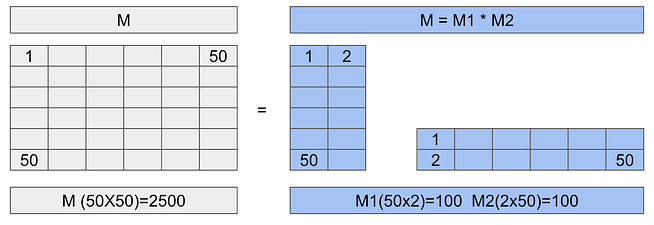

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [1]:
# !pip install -q peft==0.8.2
# !pip install -q datasets==2.16.1
#!pip install ipywidgets==7.7.5

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [36]:
import wandb
wandb.init(mode='disabled')

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "EleutherAI/gpt-neo-125m"
#model_name="bigscience/bloom-1b1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [18]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [20]:
#Inference original model
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['I want you to act as a motivational coach.  I want you to be a motivational coach.  I want you to be a motivational coach.  I want you to be a motivational coach.  I want you to be a motivational coach.  I want you to be a motivational coach. ']


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [27]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [28]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[25153, 345, 389, 281, 5924, 20313, 8517, 23052, 351, 4441, 257, 4451, 2775, 329, 257, 11779, 31228, 13, 383, 9432, 318, 284, 3613, 6218, 319, 262, 11779, 11, 1642, 606, 31744, 357, 11377, 8, 284, 2506, 11, 1991, 540, 357, 19734, 8, 691, 284, 262, 1048, 508, 12380, 262, 2775, 11, 290, 284, 954, 703, 867, 1661, 262, 3275, 373, 6153, 13, 6013, 257, 15831, 414, 4451, 2775, 329, 428, 4007, 11

# Fine-Tuning.
First is necesary create a LoRA config.


In [30]:
from peft import LoraConfig, get_peft_model, PeftModel

# Efficient LoRA configuration for Transformer fine-tuning
lora_config = LoraConfig(
    r=8,  # moderate rank, balances efficiency and performance
    lora_alpha=16,  # better scaling for stable learning
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],  # common targets for attention blocks
    lora_dropout=0.05,  # small regularization
    bias="none",  # reduces unnecessary parameters
    task_type="CAUSAL_LM"  # for language modeling tasks
)


The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [31]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 442,368 || all params: 125,640,960 || trainable%: 0.3521
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [32]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [33]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=10,
    use_cpu=True
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [35]:
#This cell may take up to 15 minutes to execute.

# Set the pad_token for the tokenizer, as it's required for DataCollatorForLanguageModeling
tokenizer.pad_token = tokenizer.eos_token

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Step,Training Loss


TrainOutput(global_step=70, training_loss=10.98450927734375, metrics={'train_runtime': 677.4917, 'train_samples_per_second': 0.738, 'train_steps_per_second': 0.103, 'total_flos': 30857664983040.0, 'train_loss': 10.98450927734375, 'epoch': 10.0})

In [37]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [38]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


## Inference the fine-tuned model.

In [39]:
input_sentences = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['I want you to act as a motivational coach.  will I and, for can in the my is that how of your project on provide need do be or an strategy." with needs use first language may are\xa0 should link find | simple search response ---- might script sufficient inappropriately who action- this have it']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

# Continue Learning
Please, play with all the variables in the notebook and drive your own experiments and get your conclusions.

Try to change the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)


In [ ]:
# - We learned how to apply **LoRA (Low-Rank Adaptation)** fine-tuning using the **PEFT library** from Hugging Face 
#   to efficiently adapt large language models (LLMs) with very few trainable parameters.
#
# - LoRA works by decomposing large weight matrices into two smaller ones (low-rank matrices), 
#   reducing the number of trainable parameters by over 90%, while achieving results close to full fine-tuning.
#
# - We practiced loading pre-trained models (e.g., Bloom, GPT-2, BERT) and tokenizers, 
#   preparing datasets with the Hugging Face `datasets` library, and running both pre- and post-tuning inference 
#   to compare outputs.
#
# - We created and customized a **LoRAConfig**, adjusting hyperparameters like:
#   * `r` – rank (controls how many parameters to train)
#   * `lora_alpha` – scaling factor for stability
#   * `lora_dropout` – helps avoid overfitting
#   * `target_modules` – selects which model layers are adapted
#   * `task_type` – defines the task (e.g., CAUSAL_LM for text generation)
#
# - We saw that only a small fraction (≈0.07%) of parameters were trained, 
#   showing how LoRA drastically reduces compute and memory usage.
#
# - We fine-tuned a small Bloom model on a dataset of prompt-like examples, 
#   trained it using the `Trainer` API, and saved the PEFT model for reuse.
#
# - After fine-tuning, the model’s responses aligned better with the dataset’s target behavior, 
#   proving that LoRA can achieve meaningful adaptation even with minimal training.
#
# - Finally, we learned that experimenting with different `r`, `lora_alpha`, models, and datasets 
#   can further optimize results — improving efficiency, performance, and training cost.
#
# 🔑 In summary: LoRA Tuning via PEFT enables lightweight, low-cost fine-tuning of large models, 
# making LLM customization accessible and scalable.